In [1]:
from __future__ import division
from __future__ import print_function

import numpy as np
import pandas as pd
import scipy as sp 
import sys
from collections import OrderedDict
import argparse
from scipy.spatial.distance import pdist
import scipy.cluster.hierarchy as sch
from scipy.stats import hypergeom

sys.path.insert(0 , "../codes")
from IOutils import loadCellData, readListFromFile
import clusterByMeanExpr as clFuncs 

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["pdf.fonttype"] = 42
%matplotlib inline 
plt.rcParams["axes.labelsize"] = "x-large"
plt.rcParams["xtick.labelsize"] =  "large"
plt.rcParams["ytick.labelsize"] =  "large"
plt.rcParams["legend.fontsize"] = "x-large"

In [2]:
#################################################################
## FUNCTIONS
## LOAD DATA
def load_motifEffectSizes(fname_motifEnrich , col_effectSize):
    """
    Inputs:
        fname_motifEnrich - tsv table of differential enrichment test results. Each row is a motif
        col_effextSize - a columnt of motifEnrich table
    Returns:
        motifEnrich_df
    """
    motifEnrich_df = pd.read_csv( fname_motifEnrich, header = 0 , index_col = 0 , sep="\t" )
    motifEnrich_df = motifEnrich_df.loc[motifEnrich_df.loc[:, "reject"].copy(), ["p" , "p_adj", col_effectSize]].copy()
    ### splitindex into MotifHeader and scRNAsymbol
    motifEnrich_df["symbols_scRNAseq"] =   list(map( lambda x: x.split(" ,")[-1].strip() ,  list(motifEnrich_df.index) ))
    motifEnrich_df.index = list(map( lambda x: x.split(" ,")[0].strip() ,  list(motifEnrich_df.index) ))
    motifEnrich_df.index.name = "motifHeader"
    return  motifEnrich_df

######################################################################## 
#### Map multiple motifs enrichments to single TF
def filterMotifEnrichment_byRank( motifEnrichDF, motifRankDF ):
    """
    motifEnrichDF - DataFrame loaded with load_motifEffectSizes
    motifRankDF - DataFrame loaded via pd.read_csv(args.args.motifRank )
    """
    motifEnrich_df[["rank" , "origin"]] = motifRank_df.loc[motifEnrich_df.index , ["rank" , "origin"]  ]
    motifEnrich_df_by_symbol = motifEnrich_df.reset_index().groupby(by = "symbols_scRNAseq")
    motifEnrich_df_filtered = motifEnrich_df_by_symbol.apply( lambda x : x.loc[ x["rank"] == x["rank"].min(),  : ]   )
    motifEnrich_df_filtered.index = motifEnrich_df_filtered.index.droplevel(level = 1)
    
    return motifEnrich_df_filtered

def make_TF_effectSize_oneToOne( motifEnrich_df, effectSizeCol, combineStat = "mean" ):
    """
    Inputs
        motifEnrich_df - pandas Series. Elements of index are scRNAseq symbols or comma 
                         separated list of scRNA seq sybols (in the case of TF dimers etc.)
        combineStat - one of median , mean, max
        effectSizeCol - a column of motifEnrich_df
    """
    TF_list = [ ]
    for elem in list(motifEnrich_df.index):
        TF_list.extend(elem.split(","))
    TF_list = list(set(TF_list))
    results = pd.Series(index = TF_list)
    for TF in TF_list:
        mask = [  TF in x.split(",") for x in list( motifEnrich_df.index) ]
        if combineStat.lower() == "mean":
            results[TF] =  motifEnrich_df.loc[ mask ,  effectSizeCol].mean()
        elif combineStat.lower() == "median":
            results[TF] =  motifEnrich_df.loc[ mask ,  effectSizeCol].median()
        elif combineStat.lower() == "max":
            results[TF] =  motifEnrich_df.loc[ mask ,  effectSizeCol].max()
        else:
            raise ValueError( "combineStat value {} not recognized".format(combineStat))
    results.name = effectSizeCol
    return results
########################################################################################
### Test association between cluster label and direction of motif enrichment
def clusterDict_from_dendrogram( Z_dendro, observations ):
    """
    Input:
        Z_dendro - output of scipy.cluster.hierarchy.dendrogram. A dictionary with keys - 
                    'color_list' , 'icoord', 'dcoord', 'leaves'
        observations - Labels of rows/ columns of distance matrix used for clustering
    Returns
        clustLabelDict - Keys are cluster colors , values are list of observations
                        belonging to cluster
    """
    clustID_leafXlabels = []
    for color, Icoord , Dcoord in zip(  Z_dendro['color_list'],   Z_dendro["icoord"],  Z_dendro["dcoord"]) :
        if Dcoord[0] ==0.0:
            clustID_leafXlabels.append(( color , Icoord[0]   )  )
        if Dcoord[-1] ==0.0:
            clustID_leafXlabels.append(( color , Icoord[-1]  ) )

    clustID_leafXlabels =  sorted( clustID_leafXlabels , key = lambda x: x[1] )
    clusterLabels = set( [ elem[0] for elem in  clustID_leafXlabels  ] )
    observations_ordered = list(np.array(observations)[Z_dendro['leaves']] )                                       
    clustLabelDict =  { clustLabel : 
                       [ observations_ordered[i]  for i , elem in enumerate( clustID_leafXlabels ) if elem[0] == clustLabel]  \
                       for clustLabel in  clusterLabels  }
    return  clustLabelDict

def test_ExpressionMotifEnrich_assn( motifSet1 , motifSet2, exprClusts_dict ):
    """
    Inputs:
        motifSet1 - list of TF names
        motifSet2 - list of TF names
        exprClusts_dict - dict with keys -> colors , values -> lists of TFs
    Returns:
        P-values for association between motifEnricherClust1  motifEnrichClust2 and different partition of TFs based on colors
    """
    def make_partitions(collection):
        """
        copied from: https://stackoverflow.com/questions/19368375/set-partitions-in-python 
        """
        if len(collection) == 1:
            yield [ collection ]
            return

        first = collection[0]
        for smaller in make_partitions(collection[1:]):
            # insert `first` in each of the subpartition's subsets
            for n, subset in enumerate(smaller):
                yield smaller[:n] + [[ first ] + subset]  + smaller[n+1:]
            # put `first` in its own subset 
            yield [ [ first ] ] + smaller 
    def FEtest(x, n, N , M , alternative = "greater"):
        """ 
        Implementation of fisher exact test based on parameters of hypergeo distribtion
        as described on scipy.stats.hypergeom webpage. If "greater" the test is if x 
        represents enriched count. If "less" is if x is depleted count
        Inputs:
            x - number of draws of success state
            n - number of success states in the population
            N - number of draws
            M - population size
        Returns:
            p , obs_to_expect , log2_obs_to_expected
        """
        if alternative == "greater":
            p =  hypergeom.cdf(k = N -x , M = M ,n = M - n , N = N ) 
        elif alternative == "less":
            p =  hypergeom.cdf(k = x , M = M ,n = n , N = N ) 
        expected =  N*(n/ float(M))
        obs_to_expected = x / expected
        if x > 0:
            log2_obs_to_expected = np.log2( x / expected)
        else:
            log2_obs_to_expected = np.nan
        return p , obs_to_expected , log2_obs_to_expected
    
    exprClust_labels = list(exprClusts_dict.keys())
    partitions = [ x for x in  make_partitions(exprClust_labels) if len(x) ==2 ]
    
    population = set(motifSet1).union(motifSet2)
    results = []
    for partition in partitions:
        exprClust1 =  set([ item for key in partition[0] for item in  exprClusts_dict[key] ] ).intersection(population)
        exprClust1_name = ",".join(partition[0] )
        exprClust2 = set([ item for key in partition[1] for item in  exprClusts_dict[key] ]).intersection(population)
        exprClust2_name = ",".join(partition[1] )
        
        p_1_1_enrich , _, _ = FEtest( x =  len( exprClust1.intersection(set(motifSet1) ) ),
                                       n =len(set(motifSet1 )) ,
                                       N = len(set( exprClust1 )) ,
                                       M = len(population),
                                      alternative = "greater" )
        p_2_1_enrich , _, _ = FEtest( x =  len( exprClust2.intersection(set(motifSet1) ) ),
                                       n =len(set(motifSet1 )) ,
                                       N = len(set( exprClust2)) ,
                                       M = len(population),
                                      alternative = "greater" )
        if  p_1_1_enrich < p_2_1_enrich:
            results.append( [exprClust1_name  , exprClust2_name ,    p_1_1_enrich ] )
        else:
            results.append( [exprClust2_name  , exprClust1_name ,    p_2_1_enrich]  )
        
    results_df = pd.DataFrame(results , columns = ["enriched_in_motifSet1" , "complement" , "p"])  
    return results_df 

In [7]:
parser = argparse.ArgumentParser(description= "Make heatmap of TF expression vs stage \
and differential enrichment of corresponding motifs" )
parser.add_argument( "--motifEnrich", 
                        help = "Table of results of differential Motif Enrichment. Must have column reject (which is True when can reject null)")
parser.add_argument( "--effectSize" , help = "column of motifEnrich to use for plotting" )
parser.add_argument( "--motifRank" , help ="file with lines:\
        MotifName     scRNAseqTF    Priority rank\n\
        TP63_motif_a   TP63     1\n\
        TP63_motif_b   TP63     2\n\
        ...\n\
        Priority Ranks used to determine motif enrichment shown in headmap" )
parser.add_argument("--exprTable" )
parser.add_argument("--cells_allowed")
parser.add_argument("--stageLabels")
parser.add_argument('--geneNames' , help = "list of geneNames to be clustered. Can be comma sep list of files" , required = False )
parser.add_argument('--minLog2FC', type = float ,
                    help= "Minimum magnitude of log2FC (between 2 stages) for gene to be considered in anaylsis")
parser.add_argument('--linkage' , default = "average")
parser.add_argument("-o" , help = "output filename")
parser.add_argument("--stagesAllowed" , help="comma separated list of ints")
parser.add_argument("--logTPM" , action = "store_true" )
parser.add_argument("--dendroThresh" , type = float)
parser.add_argument("--minExpr" , type = float)

exampleInput = "--motifEnrich ../motifAnalysis/BK-SE.unique_Vs_BK-SE.unique_kcyteTFs.threshE-4.mannWhit.tsv \
--effectSize  zScore \
--motifRank ../motifAnalysis/motifs_kcyteTFs.rank.txt \
--exprTable  ../impute/magic_counts_t4_cells.foreskin_genesGeq1Pct.kcyte.pkl \
--cells_allowed ../exprCorr/cellNames.passFilter.txt \
--stageLabels ../clusterCells/kasp.ka10.k30_impute.t10_gene.geq5UMIgeq100Cell.all.csv \
--geneNames ../setsGenes/kcyte_TFs.txt \
--stagesAllowed 1,2,3,4,5,6,7 \
--minLog2FC 0.807355 \
--linkage average \
--logTPM \
--minExpr 0.05 \
--dendroThresh 1.2 \
-o TFexpr_bindingMoitf_assn.clustMap.pdf"
## minLog2FC 0.807355  = log2(1.75) -> max( mean stage expression ) 
##                                at least 75% greater than min(mean stage expression)

args = parser.parse_args(exampleInput.split())
stagesAllowed = [int(x) for x in args.stagesAllowed.split(",")]

In [10]:
############################################################################################
#### LOAD DATA 
motifEnrich_df = load_motifEffectSizes(args.motifEnrich , args.effectSize)
motifRank_df = pd.read_csv( args.motifRank , index_col = 0 , header = 0 , sep = "\t" )

exprDF = loadCellData( fnameDict = OrderedDict([ ("expr", args.exprTable ) , ("pcComps" , args.stageLabels)] ) )
cells_pass = readListFromFile(args.cells_allowed)  
exprDF = exprDF.loc[cells_pass,:].copy()
geneNames = readListFromFile(args.geneNames )
nGeneCandidates = len(geneNames)
print("Loaded Symbols of {} candidates for gene clustering".format(nGeneCandidates) )

loading Files
	loading file ../impute/magic_counts_t4_cells.foreskin_genesGeq1Pct.kcyte.pkl
	loading file ../clusterCells/kasp.ka10.k30_impute.t10_gene.geq5UMIgeq100Cell.all.csv
Summary of Join:
	expr : 22338 of 22338 in join
	pcComps : 22338 of 22338 in join
Loaded Symbols of 93 candidates for gene clustering


In [11]:
############################################################################################
## Map mutliple motif scores to single TF
motifEnrich_df = filterMotifEnrichment_byRank( motifEnrichDF = motifEnrich_df.copy(),
                                                 motifRankDF = motifRank_df.copy() )
TF_effectSize_series = make_TF_effectSize_oneToOne( motifEnrich_df = motifEnrich_df ,
                                               effectSizeCol = "zScore", combineStat = "mean" )
##########################################################################################
## Compute StageWise Mean expr 
meanExpr = exprDF["expr"].groupby( by = exprDF["rowData"].loc[: , "clust_ID"] ).apply(lambda x: x.mean(axis = 0))
############################################################################################
## Filter by foldChange
meanExpr = meanExpr.loc[stagesAllowed, geneNames].copy()
if args.minLog2FC is not None:
    if args.minExpr:
        print("Filtering genes list to those with magnituded logFC geq {} (enforcing min expression {} in LFCcalc)".format(args.minLog2FC, args.minExpr)  )
        lfcMaxMin = meanExpr.apply( lambda x: np.log2(x.max()/ max(x.min(), args.minExpr ) ) , axis = 0)
    else:
        print("Filtering genes list to those with magnituded logFC geq {}".format(args.minLog2FC )  )
        lfcMaxMin = meanExpr.apply( lambda x: np.log2(x.max()/ x.min()) , axis = 0) 
    mask =  lfcMaxMin < args.minLog2FC
    meanExpr = meanExpr.loc[: , ~mask].copy()
    print("{} of {} gene candidiates remain after LFC filter".format(meanExpr.shape[1] , nGeneCandidates ))
    
##########################################################################################
## CLUSTER PREPROCESSING 
if args.logTPM:
    meanExpr = np.log10(meanExpr*100.0 + 1.0)
plotData = (meanExpr.subtract(meanExpr.mean(axis = 0))).divide( meanExpr.std(axis = 0) ).transpose()
plotData_secondary = pd.DataFrame( [TF_effectSize_series[x] if x in TF_effectSize_series.index else np.nan for x in plotData.index] ,
                                     index = plotData.index, columns = ["DK SE\nenrichment"])

Filtering genes list to those with magnituded logFC geq 0.807355 (enforcing min expression 0.05 in LFCcalc)
51 of 93 gene candidiates remain after LFC filter


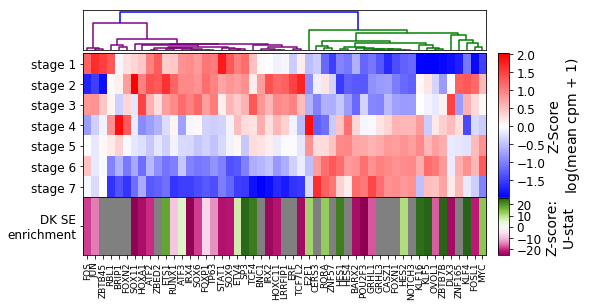

In [14]:
####################################################################################################
## CLUSTER 
dists = pdist( plotData.values.copy(), metric = "correlation"  )
linkageMat = sch.linkage(dists , method= args.linkage)
linkageMat[-1 , [0,1]] = linkageMat[-1 , [1,0]]
if args.logTPM:
    cbarLabel = 'Z-Score\n$\log$(mean cpm + 1)'
else:
    cbarLabel = 'Z-Score, mean stage expression'
if type(plotData.columns[0]) is np.int64:
    plotData.rename(columns = {i : "stage {:d}".format(i) for i in plotData.columns} , inplace = True)
    
fig , Z = clFuncs.clusterHmap(data =plotData.copy() , linkageMat= linkageMat , 
                data_secondary= plotData_secondary.copy(), 
                cmap = plt.cm.bwr, cmap_secondary =  plt.cm.PiYG , 
                cbarLabel =  cbarLabel , cbarLabel_secondary = "Z-score:\nU-stat", 
                xtickLabelFontsize = 9 ,
                ytickLabelFontsize = 12 , grid_lw=2 ,matrixHeight_secondary=0.2, 
               cbarLabelSize = 14, cbarTickLabelSize = 12 , color_threshold = args.dendroThresh  ,
               figsize=(8.0, 4), colorMinMaxPct = None, dendroColorPalette  = [ "purple", "g" ] )
fig.savefig(args.o ,format = "pdf", bbox_inches = "tight")

In [13]:
####################################################################################################
### TEST ASSOCIATION: MOTIF ENRICHMENT DIRECTION VS EXPRESSION CLUISTERS 
## FISHER EXACT
TF_effectSize_series_noNA = plotData_secondary.loc[ ~plotData_secondary.iloc[: ,0].isna(),"DK SE\nenrichment"].copy()

motifSet1 = list(TF_effectSize_series_noNA.loc[TF_effectSize_series_noNA > 0 ].index ) 
motifSet2 = list(TF_effectSize_series_noNA.loc[TF_effectSize_series_noNA < 0 ].index )
exprClusts_dict = clusterDict_from_dendrogram( Z_dendro = Z, observations  = list(plotData.index))

motifEnrichVExprClust_df = test_ExpressionMotifEnrich_assn( motifSet1 , motifSet2, exprClusts_dict =  exprClusts_dict )
motifEnrichVExprClust_df.rename( {"enriched_in_motifSet1": "enriched_for_NHEK-D_SE_motifs"}, axis = 1 , inplace = True )
print("FE one-sided p:")
display(motifEnrichVExprClust_df)

## DO MANN-WHITNEY U test on z-score of U statistics
clust_series = pd.Series( ["purple" if x in exprClusts_dict["purple"] else "green" for x in TF_effectSize_series_noNA.index ],  index= TF_effectSize_series_noNA.index  ) 

TF_effectSize_df = pd.concat( [TF_effectSize_series_noNA ,  clust_series]  ,axis = 1  )
TF_effectSize_df = TF_effectSize_df.rename( columns = {0 : "clustID"})

mw_out= sp.stats.mannwhitneyu( TF_effectSize_df.loc[ TF_effectSize_df.loc[: , "clustID"] == "purple",  'DK SE\nenrichment'].values , 
                     TF_effectSize_df.loc[ TF_effectSize_df.loc[: , "clustID"] == "green", 'DK SE\nenrichment'].values ,
                    alternative = "less" )
print("mann-whitney one sided p:")
print(mw_out)

FE one-sided p:


,enriched_for_NHEK-D_SE_motifs,complement,p
0,g,purple,0.040428


mann-whitney one sided p:
MannwhitneyuResult(statistic=98.0, pvalue=0.043020046962314415)
